In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys, os, django

sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from django.db.models import Q, F, Sum, Count, FloatField, Case, When, Value, Max
from sklearn.manifold import TSNE
from scoping.models import *

In [41]:
df = pd.read_csv('data/document_ratings.csv')
df.head()

,PY,content,id,relevant,seen,title,wosarticle__de,wosarticle__wc,1 - Adaptation,1 - Mitigation,...,1 - Mitigation - prediction,1 - Adaptation - prediction,3 - Economic instruments - prediction,3 - Goal setting - prediction,3 - Information policies - prediction,3 - International policies - prediction,3 - Planning and public provisioning/services - prediction,3 - Regulatory instruments - prediction,3 - Voluntary actions - prediction,2 - Governance & policies - prediction
0,2007,"As the area of the world's forests shrinks, th...",63856,0.0,0.0,Conserving forest biodiversity across multiple...,adaptive management; conflict; land ownership;...,['Biodiversity Conservation; Ecology; Environm...,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.875758
1,2006,"Traditionally, economic analyses of greenhouse...",377962,0.0,0.0,Mitigation of methane and nitrous oxide emissi...,0,['Economics; Energy & Fuels; Environmental Stu...,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.941099
2,2011,Milne Fiord in the Canadian High Arctic contai...,605647,0.0,0.0,Milne Fiord epishelf lake: A coastal Arctic ec...,Archaea; Arctic; bacteria; cyanobacteria; extr...,['Ecology'],0.0,0.0,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,2007,A global water model is used to analyse the im...,596366,0.0,0.0,Future long-term changes in global water resou...,global water resources; global change; water s...,['Water Resources'],0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.016445
4,2017,The Red Data Books are among the major legisla...,797846,0.0,0.0,Problems in creating lists of protected specie...,Red List; Red Data Book; IUCN criteria; IUCN c...,['Plant Sciences'],0.0,0.0,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [42]:
df.columns

Index(['PY', 'content', 'id', 'relevant', 'seen', 'title', 'wosarticle__de',
       'wosarticle__wc', '1 - Adaptation', '1 - Mitigation',
       '2 - Governance & policies', '3 - <hidden>tax/emission trading',
       '3 - Economic instruments', '3 - Goal setting',
       '3 - Government procurement & public services<hidden>',
       '3 - Information policies', '3 - Information<hidden>',
       '3 - International policies', '3 - Other<hidden>',
       '3 - Planning and public provisioning/services',
       '3 - Regulation<hidden>', '3 - Regulatory instruments',
       '3 - Subsidies<hidden>', '3 - Voluntary actions',
       '3 - voluntary agreement<hidden>', '4 - Behavioral interventions',
       '4 - Emissions trading ', '4 - Feed in tariffs',
       '4 - Financial mechanisms', '4 - Financial regulation & insurance',
       '4 - Government procurement', '4 - Infrastructure policy & management',
       '4 - Innovation policies', '4 - International agreements',
       '4 - Investments, c

In [43]:
predictions = [c for c in df.columns if "- prediction" in c]
for c in predictions:
    rating = c.replace(' - prediction','')
    df.loc[df[rating]==1,c] = 1

765


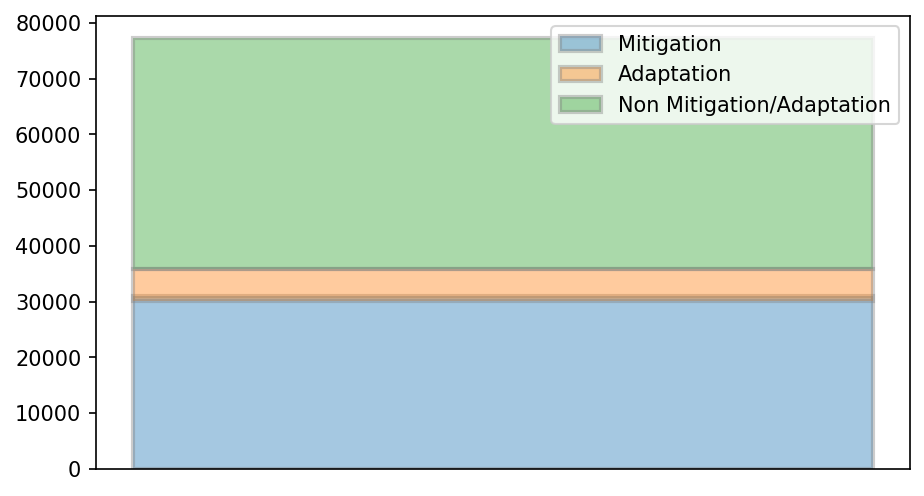

In [44]:
fig, ax = plt.subplots(dpi=150, figsize=(7,4))
df['mit/ad'] = df['1 - Mitigation - prediction'] + df['1 - Adaptation - prediction']
mitigation = df.loc[df['prediction']>0.5,'1 - Mitigation - prediction'].sum()
adaptation = df.loc[df['prediction']>0.5,'1 - Adaptation - prediction'].sum()
overlap = df.loc[df['mit/ad']==2,].shape[0]
nonmitad = df.loc[(df['prediction']>0.5) & (df['mit/ad']==0),].shape[0]

print(overlap)

lw = 2
alpha=0.4
ec = "grey"

ax.bar(
    0,mitigation,
    alpha=alpha, label="Mitigation",
    lw=lw, edgecolor=ec
)
ax.bar(
    0,adaptation,bottom=mitigation-overlap,
    alpha=alpha, label="Adaptation",
    lw=lw, edgecolor=ec
)
ax.bar(
    0,nonmitad,bottom=mitigation-overlap+adaptation,
    alpha=alpha, label="Non Mitigation/Adaptation",
    lw=lw, edgecolor=ec
)

ax.set_xticks([])

ax.legend()


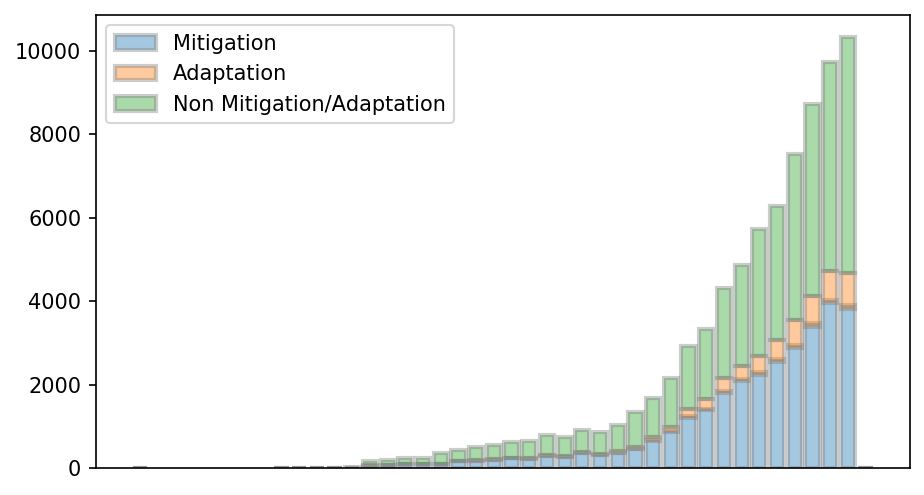

In [45]:
fig, ax = plt.subplots(dpi=150, figsize=(7,4))

labels = []

for y, group in df.groupby('PY'):
    mitigation = group.loc[group['prediction']>0.5,'1 - Mitigation - prediction'].sum()
    adaptation = group.loc[group['prediction']>0.5,'1 - Adaptation - prediction'].sum()
    overlap = group.loc[group['mit/ad']==2,].shape[0]
    nonmitad = group.loc[(group['prediction']>0.5) & (df['mit/ad']==0),].shape[0]


    lw = 2
    alpha=0.4
    ec = "grey"
    
    if len(labels)==0:
        labels = ["Mitigation", "Adaptation", "Non Mitigation/Adaptation"]
    else:
        labels = [None, None, None]

    ax.bar(
        y,mitigation,
        alpha=alpha, label=labels[0],
        lw=lw, edgecolor=ec, color="C0"
    )
    ax.bar(
        y,adaptation,bottom=mitigation-overlap,
        alpha=alpha, label=labels[1],
        lw=lw, edgecolor=ec, color="C1"
    )
    ax.bar(
        y,nonmitad,bottom=mitigation-overlap+adaptation,
        alpha=alpha, label=labels[2],
        lw=lw, edgecolor=ec, color="C2"
    )

    ax.set_xticks([])

ax.legend()

# Now just those predicted to be about gov+pol

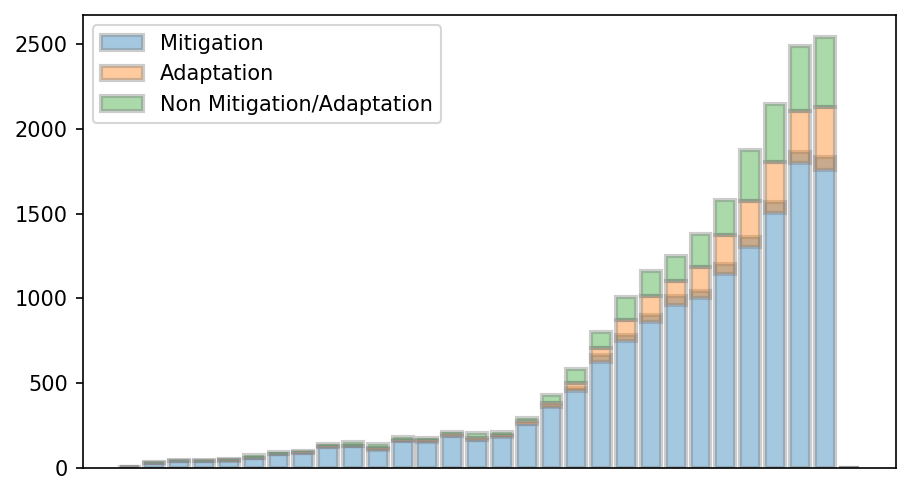

In [46]:
fig, ax = plt.subplots(dpi=150, figsize=(7,4))

labels = []

for y, group in df[df['2 - Governance & policies - prediction']>=0.5].groupby('PY'):
    mitigation = group.loc[group['prediction']>0.5,'1 - Mitigation - prediction'].sum()
    adaptation = group.loc[group['prediction']>0.5,'1 - Adaptation - prediction'].sum()
    overlap = group.loc[group['mit/ad']==2,].shape[0]
    nonmitad = group.loc[(group['prediction']>0.5) & (df['mit/ad']==0),].shape[0]


    lw = 2
    alpha=0.4
    ec = "grey"
    
    if len(labels)==0:
        labels = ["Mitigation", "Adaptation", "Non Mitigation/Adaptation"]
    else:
        labels = [None, None, None]

    ax.bar(
        y,mitigation,
        alpha=alpha, label=labels[0],
        lw=lw, edgecolor=ec, color="C0"
    )
    ax.bar(
        y,adaptation,bottom=mitigation-overlap,
        alpha=alpha, label=labels[1],
        lw=lw, edgecolor=ec, color="C1"
    )
    ax.bar(
        y,nonmitad,bottom=mitigation-overlap+adaptation,
        alpha=alpha, label=labels[2],
        lw=lw, edgecolor=ec, color="C2"
    )

    ax.set_xticks([])

ax.legend()

In [58]:
setup_query = True
if setup_query:
    p = Project.objects.get(pk=217)
    q, created = Query.objects.get_or_create(
        project=p,
        creator=User.objects.get(pk=1),
        title="mitigation adaptation policy"
    )
    print(q, created)
    
    qdf = df[
        (df['prediction']>0.5) & 
        (
            (df['1 - Mitigation - prediction']>0.5) |
            (df['1 - Adaptation - prediction']>0.5) |
            (df['2 - Governance & policies - prediction']>0.5)
        )
    ]
    
    print(qdf.shape)
    
    T = Doc.query.through
    dqs = [T(doc_id=did, query=q) for did in list(qdf['id'])]
    T.objects.bulk_create(dqs)
    q.r_count = q.doc_set.count()
    q.save()
    print(q.r_count)

mitigation adaptation policy False
(38750, 65)
38750
